# Programa Avançado em Data Science e Decisão (PADS) - Insper
## Avaliação Final – Financial Analytics
### Prof. Paloma Vaissman Uribe

## 1. Seleção de Ativos e importação dos dados

#### Bibliotecas 

In [79]:
import warnings
warnings.filterwarnings('ignore')

In [80]:
# Importa as bibliotecas necessárias
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import norm
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
from arch import arch_model
from statsmodels.tools.eval_measures import aic
import multiprocessing as mp
from functools import partial
import itertools

#### Importação dos dados

Vamos utilizar os seguintes ativos da carteira 10SIM:

* Petrobras (PETR4)
* Itaú Unibanco (ITUB4)
* Eletrobras (ELET3)
* Localiza (RENT3)
* TIM (TIMS3)
* Embraer (EMBR3)


In [81]:
# Lista de ativos
tickers = ["PETR4.SA", "ITUB4.SA", "ELET3.SA", "RENT3.SA", "TIMS3.SA", "EMBR3.SA"]

# Baixar dados
combined_data = yf.download(tickers, start="2018-01-01")['Adj Close']

[*********************100%%**********************]  6 of 6 completed


## 2. Plotar gráficos dos preços e retornos e comentar sobre heterocedasticidade condicional

#### Preços

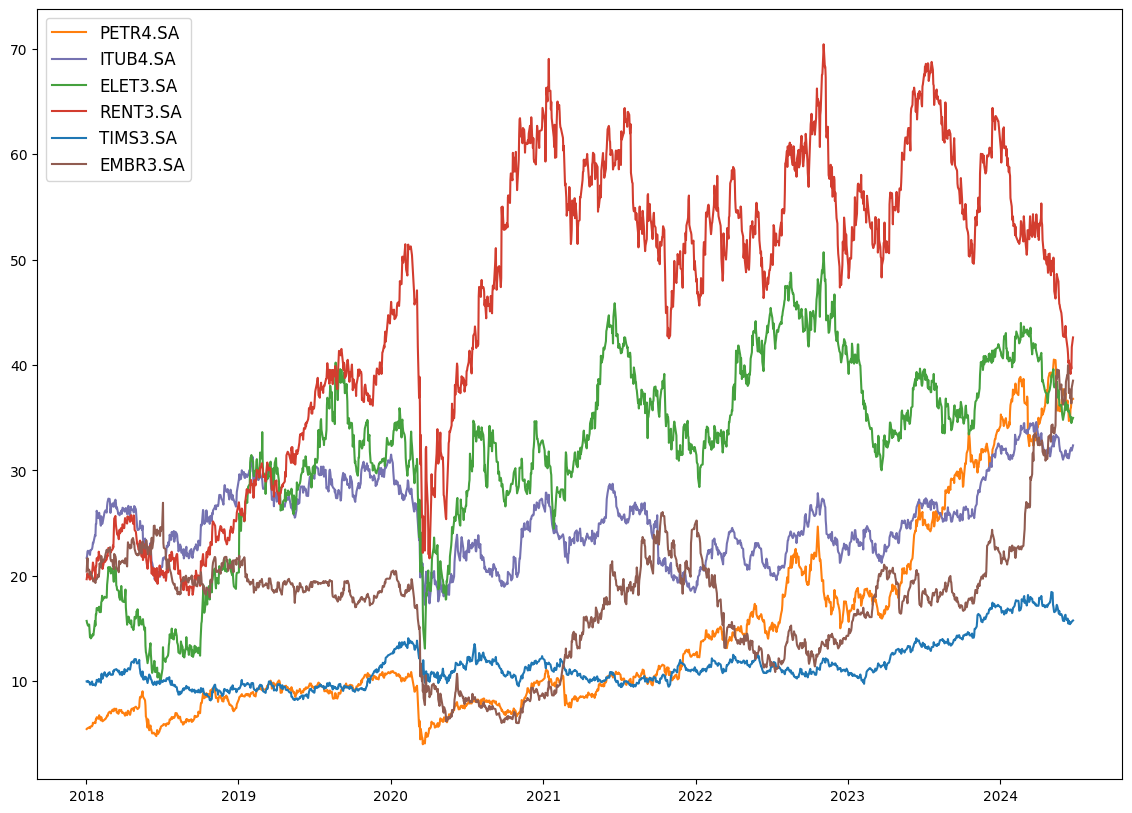

In [82]:
palette = ['#FF7F0E', '#7572B1', '#45A13E', '#D33D2F', '#1F77B4', '#905C51']
color_dict = {ticker: palette[i] for i, ticker in enumerate(tickers)}

plt.figure(figsize=(14, 10))

# Para cada ativo
for ticker in tickers:
    # Busca os dados de fechamento no df combined_data
    prices = combined_data[ticker]
    # Plota os dados de fechamento do ativo, usando a data como eixo x e os valores de fechamento como eixo y
    plt.plot(prices, label=ticker, color=color_dict[ticker])

#plt.xlabel('Data')
#plt.ylabel('Preço')
plt.legend(fontsize = 'large')
plt.show()

#### Retornos

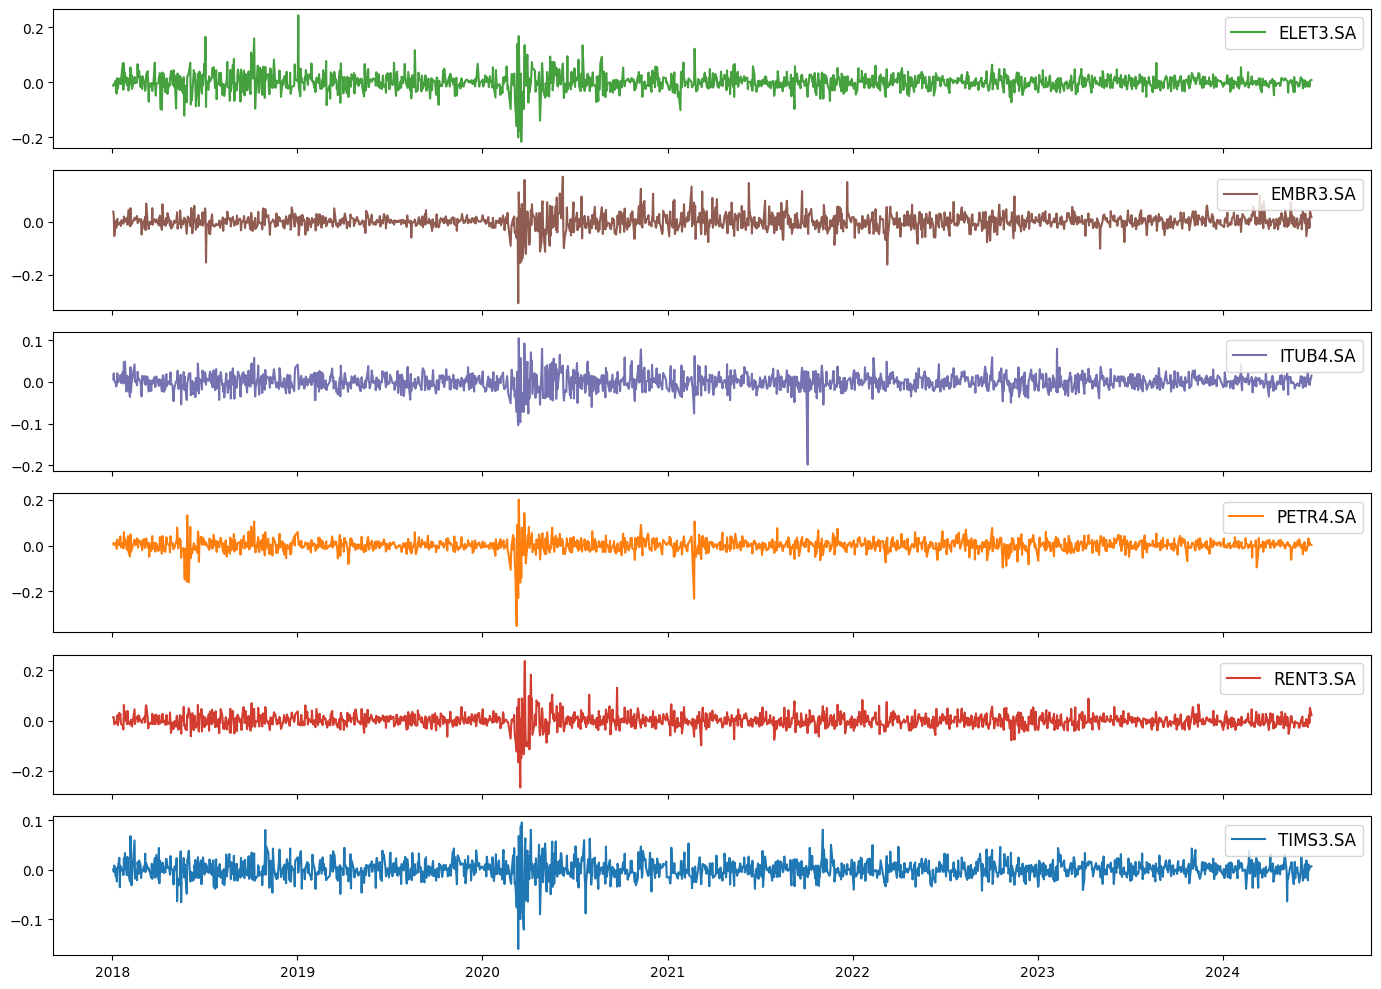

In [83]:
#Retornos
# Calcula os retornos logarítmicos diários dos ativos
returns = np.log(combined_data / combined_data.shift(1)).dropna()

fig, axes = plt.subplots(6, 1, figsize=(14, 10), sharex=True)

# Gerar os gráficos dos retornos quadráticos para cada ativo
for i, ticker in enumerate(returns.columns):
    axes[i].plot(returns.index, returns[ticker], label=ticker, color=color_dict[ticker])
    axes[i].legend(loc = 'upper right' ,fontsize = 'large')


plt.tight_layout()
plt.show()

#### Retornos quadráticos

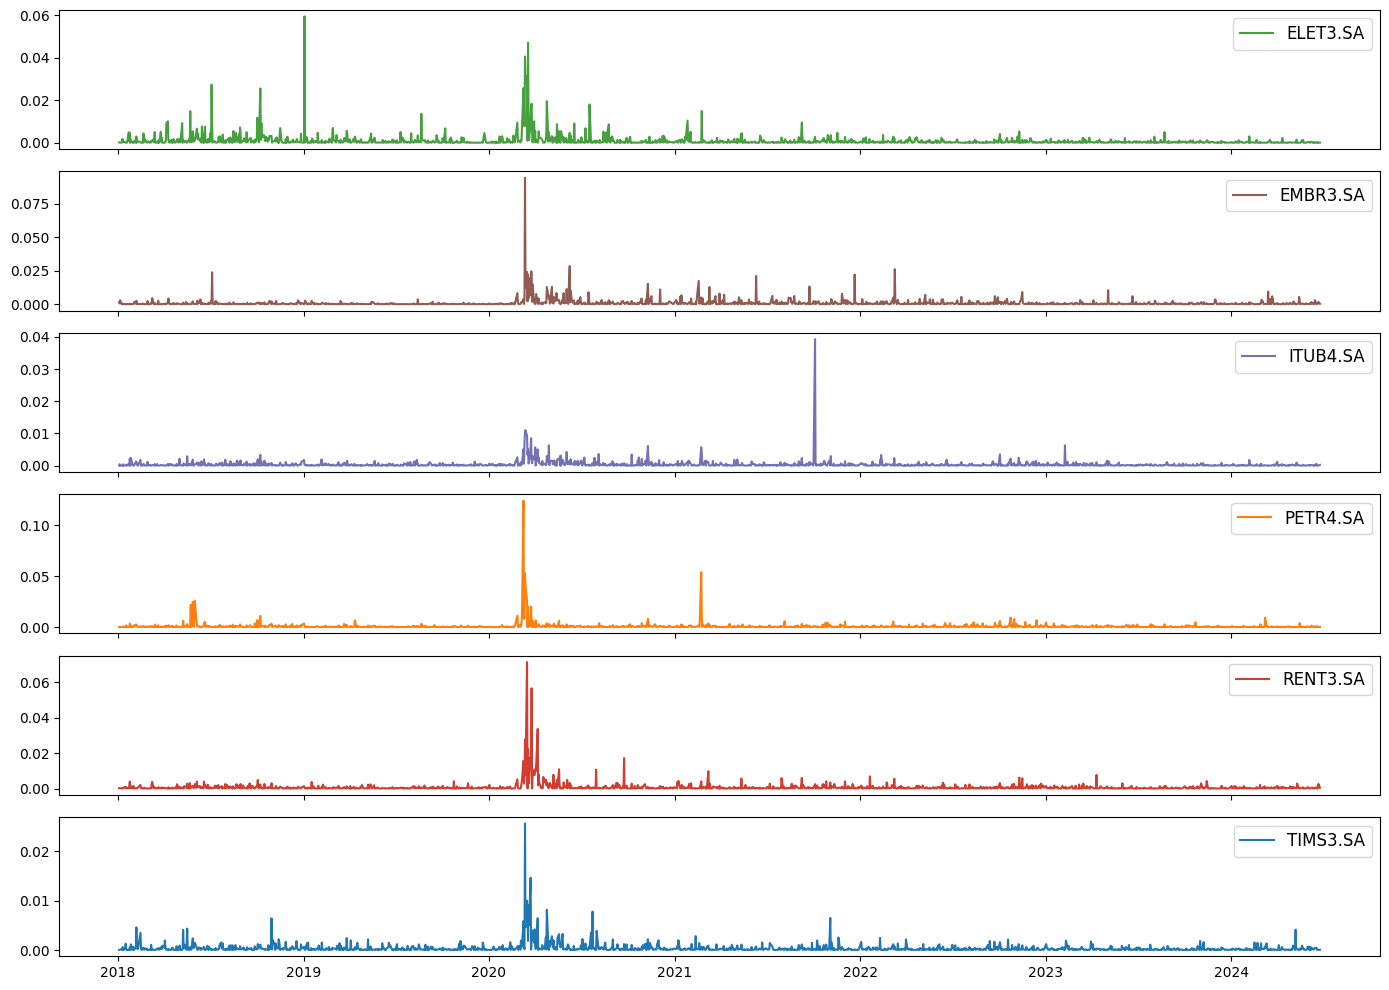

In [84]:
fig, axes = plt.subplots(6, 1, figsize=(14, 10), sharex=True)

#Retornos
# Calcula os retornos logarítmicos ao quadrado dos ativos
returns_squared = returns**2

# Gerar os gráficos dos retornos quadráticos para cada ativo
for i, ticker in enumerate(returns_squared.columns):
    axes[i].plot(returns_squared.index, returns_squared[ticker], label=ticker, color=color_dict[ticker])
    axes[i].legend(loc = 'upper right' ,fontsize = 'large')


plt.tight_layout()
plt.show()

#### Heterocedasticade condicional

Pode-se observar que a variação dos dados não é constante ao longo do tempo, há períodos que exibem volatilidade extrema, seguidos por períodos de menor volatilidade. Fica evidente o forte indício de heterocedasticidade condicional.

In [85]:
# Testar a heterocedasticidade condicional

# Ljung-Box test
for ticker in tickers:
    ljung_test = smd.acorr_ljungbox(returns_squared[ticker], lags=[1], return_df=True)
    print("\n Ljung-Box Test for {}:".format(ticker))
    print("Q-statistic:", ljung_test.lb_stat[1])
    print("p-value:", ljung_test.lb_pvalue[1])



 Ljung-Box Test for PETR4.SA:
Q-statistic: 112.52188443030282
p-value: 2.746169772413281e-26

 Ljung-Box Test for ITUB4.SA:
Q-statistic: 56.9119757112607
p-value: 4.5576193451601604e-14

 Ljung-Box Test for ELET3.SA:
Q-statistic: 125.68726421831164
p-value: 3.5996692156994454e-29

 Ljung-Box Test for RENT3.SA:
Q-statistic: 74.7698295723098
p-value: 5.289184777353256e-18

 Ljung-Box Test for TIMS3.SA:
Q-statistic: 84.16480761441665
p-value: 4.552017935220718e-20

 Ljung-Box Test for EMBR3.SA:
Q-statistic: 51.72407201535227
p-value: 6.387479077909683e-13


A hipótese nula é que não existe autocorrelações nas séries, o p-valor é muito menor do que 0.05 em todos os casos, por isso rejeitamos a hipótese nula. A presença de autocorrelação significativa nos retornos quadráticos indica heterocedasticidade condicional, ou seja, a variância dos retornos depende dos valores passados.

## 3. Ajustar modelos de volatilidade univariados e escolher o mais adequado

Agora são aplicados os seguintes passos para cada ativo:

1 - Verificar normalidade e identificar a quantidade de lags necessária através das ACFs dos retornos quadráticos

2 - Fazer a otimização de parâmetros e identificar o melhor modelo (AIC)

3 - Ajustar os modelos

4 - Prever a volatilidade 1 passo a frente

#### Funções

In [86]:
def garch_aic(parms, ret):
    garch_model = arch_model(ret, p=parms['p'], q=parms['q'], vol = parms['vol'], dist=parms['dist'])
    try:
        fit = garch_model.fit(disp="off")
        return {'p': parms['p'], 'q': parms['q'], 'vol': parms['vol'],'dist': parms['dist'], 'AIC': fit.aic}
    except:
        return {'p': parms['p'], 'q': parms['q'], 'vol': parms['vol'], 'dist': parms['dist'], 'AIC': np.inf}


In [87]:
# Para checar a normalidade
def check_normality(returns_unstacked, ticker):
    returns = returns_unstacked[ticker]
    # Faz o fit da distribuição normal nos retornos
    mu, std = norm.fit(returns)
    # Cria subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    # Plota o Histograma
    axes[0].hist(returns, bins=50, density=True, alpha=0.75)
    xmin, xmax = axes[0].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    axes[0].plot(x, p, 'k', linewidth=2)
    axes[0].set_title('Histograma dos retornos de {}'.format(ticker))
    axes[0].set_xlabel('Retornos')
    axes[0].set_ylabel('Frequência')
    # Plota o Normal Q-Q plot
    sm.qqplot(returns, line='s', ax=axes[1])
    axes[1].set_title('Normal Q-Q plot {}'.format(ticker))
    plt.tight_layout()
    plt.show()
    # Faz o Shapiro-Wilk test
    shapiro_test = stats.shapiro(returns)
    print(f"Shapiro-Wilk test statistic: {shapiro_test.statistic}")
    print(f"p-value: {shapiro_test.pvalue}")

In [88]:
#Para plotar o ACF dos retornos quadráticos
def plot_acf_returns2(squared_returns_unstacked, ticker):
    squared_returns = squared_returns_unstacked[ticker]
    fig, ax = plt.subplots(figsize=(14, 5))
    plot_acf(squared_returns, lags=60, auto_ylims= True, ax = ax)
    plt.title('ACF dos Retornos quadráticos - {}'.format(ticker))
    plt.tight_layout()
    plt.show()


In [89]:
#Para plotar os resíduos, fazer o ljung-box test e verificar AIC e BIC
def plot_residuals(fit_arch):
    # Calcula os resíduos normalizados
    resi = fit_arch.resid / fit_arch.conditional_volatility

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(resi)
    plt.title('Resíduos Normalizados')
    plt.xlabel('Tempo')
    plt.ylabel('Residuos Normalizados')

    # ACF
    plt.subplot(1, 2, 2)
    plot_acf(resi, ax=plt.gca())
    plt.title('ACF dos Resíduos Normalizados')
    plt.tight_layout()
    plt.show()

    #Ljung-Box test resíduo
    ljung_box_test = acorr_ljungbox(resi, lags=[20], return_df=True)
    print("\n Resultados do Ljung-Box Test para verificar se os resíduos são RB:")
    print(ljung_box_test)

    #Ljung-Box test resíduos quadráticos
    resi2 = resi**2
    ljung_box_test = acorr_ljungbox(resi2, lags=[20], return_df=True)
    print("\n Resultados do Ljung-Box Test para verificar se os resíduos quadráticos são RB:")
    print(ljung_box_test)

    # AIC e BIC
    print("\n AIC: ", fit_arch.aic)
    print("\n BIC: ", fit_arch.bic)

In [90]:
def combine_params(param_grid_garch, param_grid_arch):
    param_combinations_arch = list(itertools.product(*param_grid_arch.values()))
    param_combinations_garch = list(itertools.product(*param_grid_garch.values()))
    param_grid_arch_df = pd.DataFrame(param_combinations_arch, columns=param_grid_arch.keys())
    param_grid_garch_df = pd.DataFrame(param_combinations_garch, columns=param_grid_garch.keys())
    param_grid = pd.concat([param_grid_arch_df, param_grid_garch_df], ignore_index=True)
    return param_grid

### Petrobras (PETR4)

#### Verificar normalidade e plotar ACF

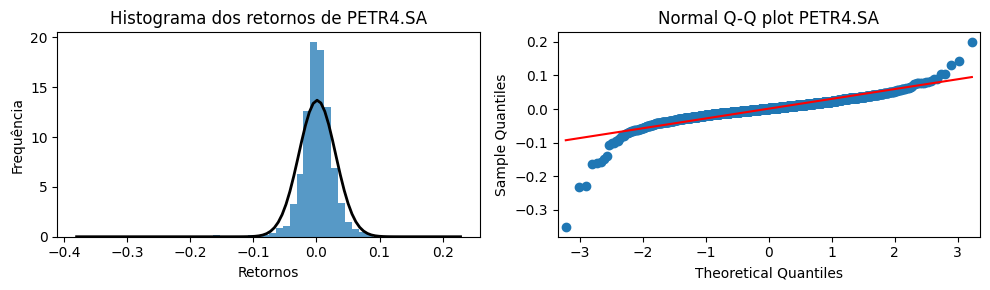

Shapiro-Wilk test statistic: 0.8511067681836328
p-value: 1.9924478851824557e-36


In [91]:
check_normality(returns, 'PETR4.SA')

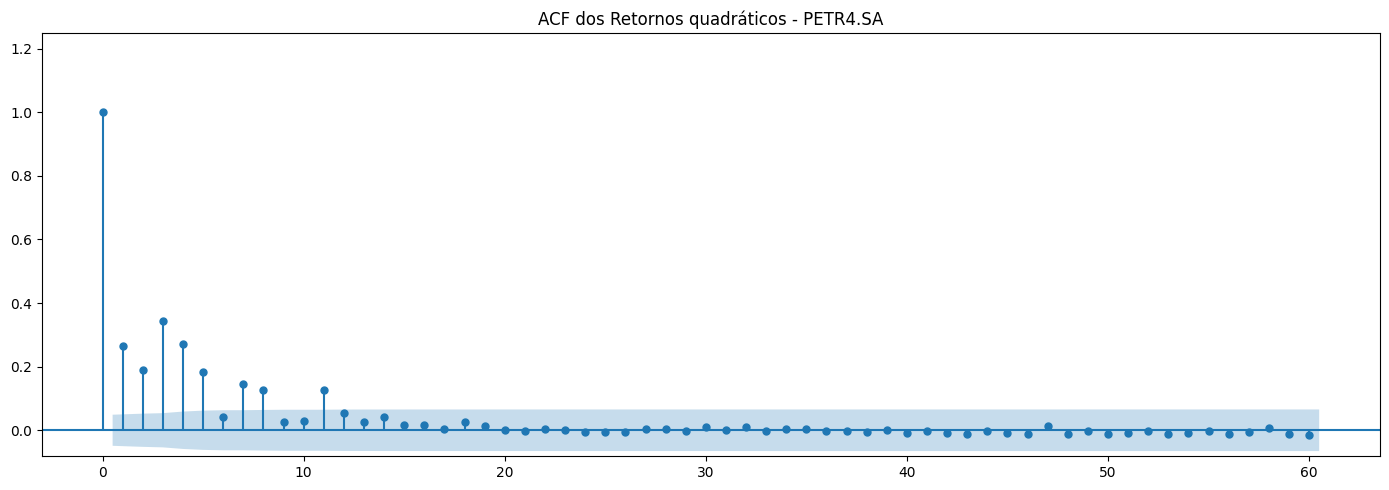

In [92]:
plot_acf_returns2(returns_squared, 'PETR4.SA')

#### Grid de parâmetros

In [93]:
#Define grid de parametros
param_grid_arch_petro = {
    'p': [5, 8, 11],
    'q': [1],
    'vol': ['ARCH'],
    'dist': ['studentst', 'skewstudent', 'ged', 'gaussian', 'normal']
}

param_grid_garch = {
    'p': [1, 2, 3],
    'q': [1, 2, 3],
    'vol': ['GARCH'],
    'dist': ['studentst', 'skewstudent', 'ged', 'gaussian', 'normal']
}

param_grid_petro = combine_params(param_grid_garch, param_grid_arch_petro)
param_list_petro = param_grid_petro.to_dict('records')


In [94]:
# Apply garch_aic function to each parameter set
results = []
for parms in param_list_petro:
    result = garch_aic(parms, returns['PETR4.SA'])
    results.append(result)
# Convert results to DataFrame
results_df = pd.DataFrame(results)

c:\Users\Giovana\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Giovana\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Giovana\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Giovana\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:

#### Ajustar os modelos

In [95]:
# 5 combinacoes com os menores AIC
results_df = results_df.sort_values('AIC')
results_df.head(5)

,p,q,vol,dist,AIC
50,3,2,GARCH,studentst,-7492.151860
35,2,2,GARCH,studentst,-7490.179019
40,2,3,GARCH,studentst,-7464.789747
17,1,1,GARCH,ged,-7436.879815
27,1,3,GARCH,ged,-7435.387274


In [96]:
top_result = results_df.head(1)
p = int(top_result['p'].values[0])
q = int(top_result['q'].values[0])
vol = top_result['vol'].values[0]
dist = top_result['dist'].values[0]

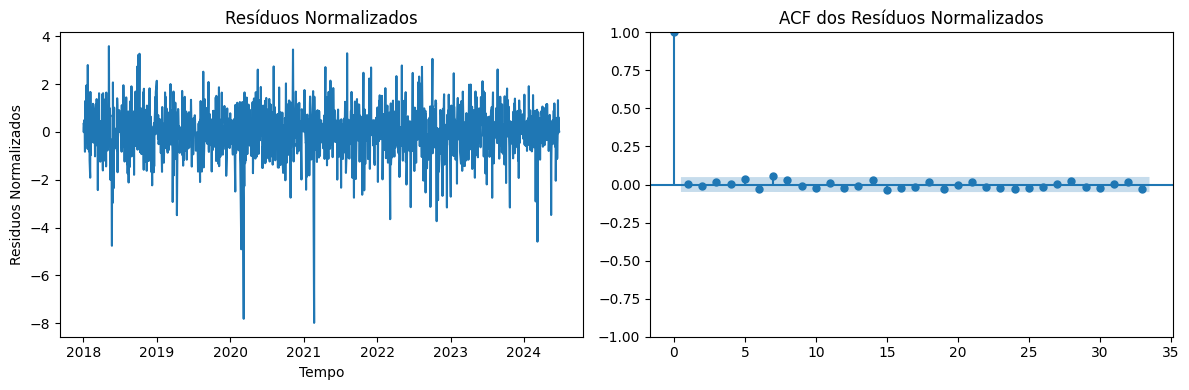


 Resultados do Ljung-Box Test para verificar se os resíduos são RB:
      lb_stat  lb_pvalue
20  19.977595   0.459332

 Resultados do Ljung-Box Test para verificar se os resíduos quadráticos são RB:
      lb_stat  lb_pvalue
20  27.861393   0.112721

 AIC:  -7492.151860372718

 BIC:  -7449.099845216664


In [97]:
# Filtra dados
ret_petro = returns['PETR4.SA']
#aplica o modelo escolhido
arch_petro = arch_model(ret_petro, p=p, q =q, vol = vol, dist = dist).fit(disp='off')
plot_residuals(arch_petro)

In [98]:
sigma_petro = arch_petro.conditional_volatility
sigma_petro_df = sigma_petro.to_frame().rename(columns={'cond_vol': 'PETR4.SA'})

Resíduos padronizados e homoscedásticos, não apresentam autocorrelação significativa.
Modelo escolhido devido a menores valores de AIC


#### Volatilidade 1 passo a frente

In [99]:
# Prever volatilidade 1 passo a frente
forecast_petro = arch_petro.forecast(horizon=1)
print(forecast_petro.variance)

                 h.1
Date                
2024-06-24  0.000405


### Itaú Unibanco (ITUB4)


#### Verificar normalidade e plotar ACF

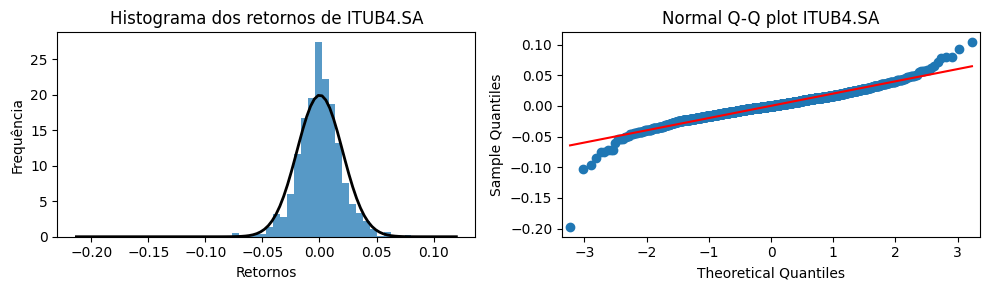

Shapiro-Wilk test statistic: 0.9459205589592659
p-value: 8.052972948820857e-24


In [100]:
check_normality(returns, 'ITUB4.SA')

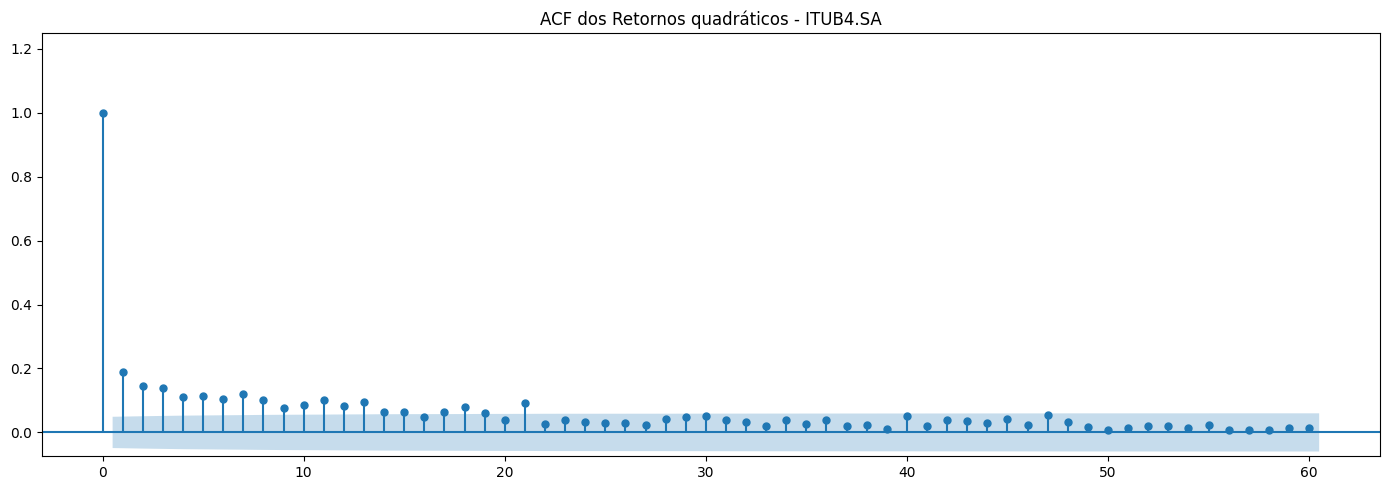

In [101]:
plot_acf_returns2(returns_squared, 'ITUB4.SA')

#### Grid de parâmetros

In [102]:
#Define grid de parametros
param_grid_arch_ita = {
    'p': [13, 18, 21],
    'q': [1],
    'vol': ['ARCH'],
    'dist': ['studentst', 'skewstudent', 'ged', 'gaussian', 'normal']
}

param_grid_ita = combine_params(param_grid_garch, param_grid_arch_ita)
param_list_ita = param_grid_ita.to_dict('records')

In [103]:
# Applicar garch_aic para cada conjunto de parametros
results = []
for parms in param_list_ita:
    result = garch_aic(parms, returns['ITUB4.SA'])
    results.append(result)

results_df = pd.DataFrame(results)

c:\Users\Giovana\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Giovana\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Giovana\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Giovana\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:

#### Ajustar os modelos

In [104]:
# 5 combinacoes com os menores AIC
results_df = results_df.sort_values('AIC')
results_df.head(5)

,p,q,vol,dist,AIC
21,1,2,GARCH,skewstudent,-8370.631905
25,1,3,GARCH,studentst,-8370.230715
10,21,1,ARCH,studentst,-8368.610337
26,1,3,GARCH,skewstudent,-8368.230590
0,13,1,ARCH,studentst,-8366.870034


In [105]:
top_result = results_df.head(1)
p = int(top_result['p'].values[0])
q = int(top_result['q'].values[0])
vol = top_result['vol'].values[0]
dist = top_result['dist'].values[0]

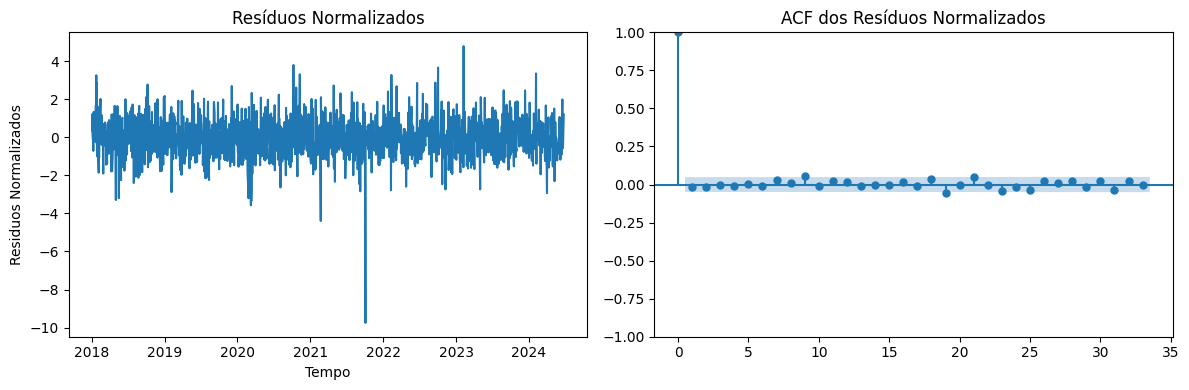


 Resultados do Ljung-Box Test para verificar se os resíduos são RB:
      lb_stat  lb_pvalue
20  16.890476   0.660074

 Resultados do Ljung-Box Test para verificar se os resíduos quadráticos são RB:
     lb_stat  lb_pvalue
20  5.491969    0.99943

 AIC:  -8370.631905176582

 BIC:  -8332.961391915036


In [106]:
ret_ita = returns['ITUB4.SA']
#aplica o modelo escolhido
garch_ita = arch_model(ret_ita, p=p, q = q, vol = vol, dist = dist).fit(disp='off')
plot_residuals(garch_ita)

Resíduos padronizados e homoscedásticos, não apresentam autocorrelação significativa.
Modelo escolhido devido a menores valores de AIC


In [107]:
sigma_ita = garch_ita.conditional_volatility
sigma_ita_df = sigma_ita.to_frame().rename(columns={'cond_vol': 'ITUB4.SA'})

#### Volatilidade 1 passo a frente

In [108]:
# Prever volatilidade 1 passo a frente
forecast_ita = garch_ita.forecast(horizon=1)
print(forecast_ita.variance)

                 h.1
Date                
2024-06-24  0.000165


### Eletrobras (ELET3)

#### Verificar normalidade e plotar ACF

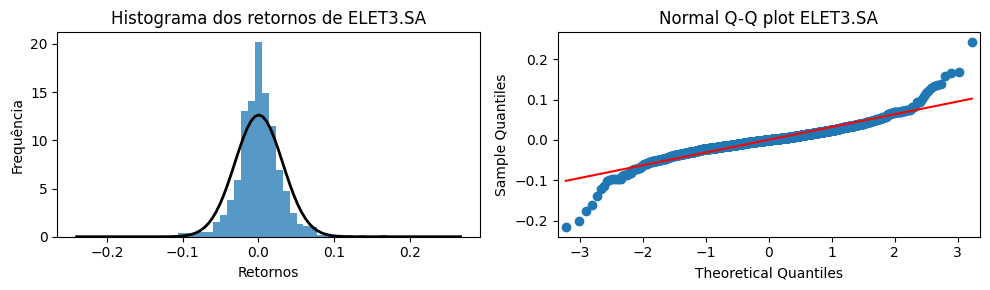

Shapiro-Wilk test statistic: 0.9134298249913665
p-value: 2.5082531831448675e-29


In [109]:
check_normality(returns, 'ELET3.SA')

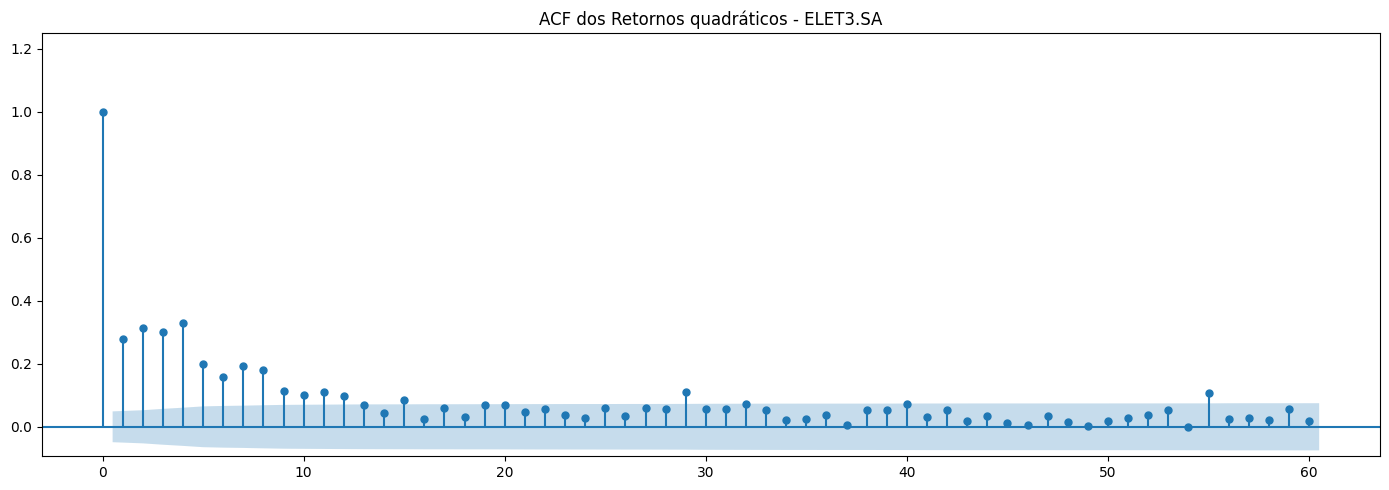

In [110]:
plot_acf_returns2(returns_squared, 'ELET3.SA')

#### Grid de parâmetros

In [111]:
#Define grid de parametros
param_grid_arch_elet = {
    'p': [12, 15, 29],
    'q': [1],
    'vol': ['ARCH'],
    'dist': ['studentst', 'skewstudent', 'ged', 'gaussian', 'normal']
}

param_grid_elet = combine_params(param_grid_garch, param_grid_arch_elet)
param_list_elet = param_grid_elet.to_dict('records')

In [112]:
# Aplicar garch_aic para cada conjunto de parametros
results = []
for parms in param_list_elet:
    result = garch_aic(parms, returns['ELET3.SA'])
    results.append(result)

results_df = pd.DataFrame(results)

c:\Users\Giovana\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Giovana\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Giovana\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Giovana\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality

#### Ajustar os modelos

In [113]:
# 5 combinacoes com os menores AIC
results_df = results_df.sort_values('AIC')
results_df.head(5)

,p,q,vol,dist,AIC
15,1,1,GARCH,studentst,-7135.953547
16,1,1,GARCH,skewstudent,-7133.969137
45,3,1,GARCH,studentst,-7131.953482
35,2,2,GARCH,studentst,-7129.630773
21,1,2,GARCH,skewstudent,-7127.821211


In [114]:
top_result = results_df.head(1)
p = int(top_result['p'].values[0])
q = int(top_result['q'].values[0])
vol = top_result['vol'].values[0]
dist = top_result['dist'].values[0]

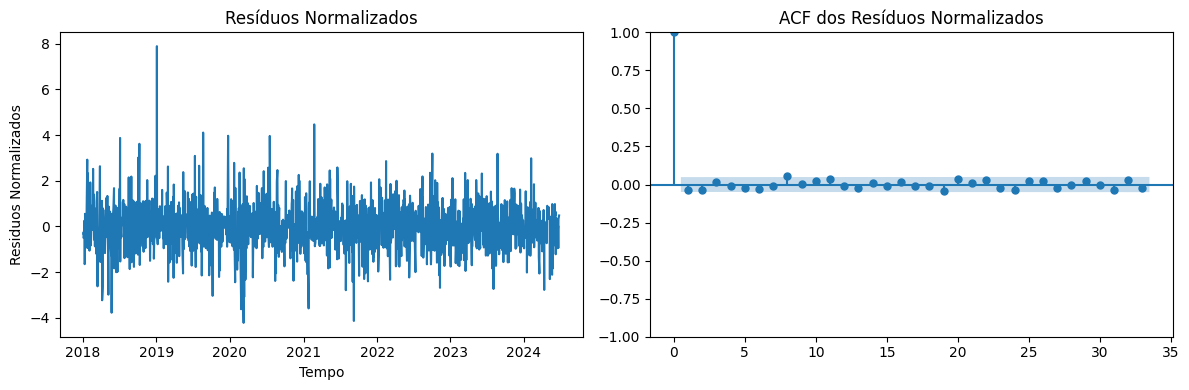


 Resultados do Ljung-Box Test para verificar se os resíduos são RB:
      lb_stat  lb_pvalue
20  23.184264   0.279838

 Resultados do Ljung-Box Test para verificar se os resíduos quadráticos são RB:
     lb_stat  lb_pvalue
20  8.756508    0.98556

 AIC:  -7135.953546773838

 BIC:  -7109.046037301305


In [115]:
ret_ele = returns['ELET3.SA']
#aplica o modelo escolhido
garch_ele = arch_model(ret_ele, p=p, q = q, vol = vol, dist = dist).fit(disp='off')
plot_residuals(garch_ele)

In [116]:
sigma_ele = garch_ele.conditional_volatility
sigma_ele_df = sigma_ele.to_frame().rename(columns={'cond_vol': 'ELET3.SA'})

#### Volatilidade 1 passo a frente

In [117]:
# Prever volatilidade 1 passo a frente
forecast_ele = garch_ele.forecast(horizon=1)
print(forecast_ele.variance)

                 h.1
Date                
2024-06-24  0.000285


Resíduos padronizados e homoscedásticos, não apresentam autocorrelação significativa.
Modelo escolhido devido a menores valores de AIC

### Localiza (RENT3)

#### Verificar normalidade e plotar ACF

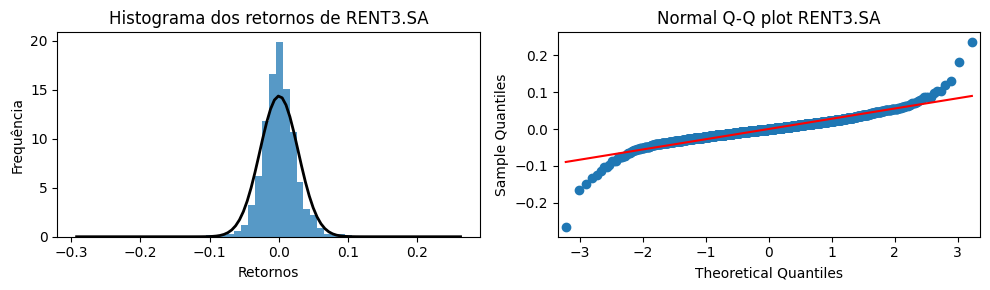

Shapiro-Wilk test statistic: 0.9067807022899157
p-value: 3.006509016398388e-30


In [118]:
check_normality(returns, 'RENT3.SA')

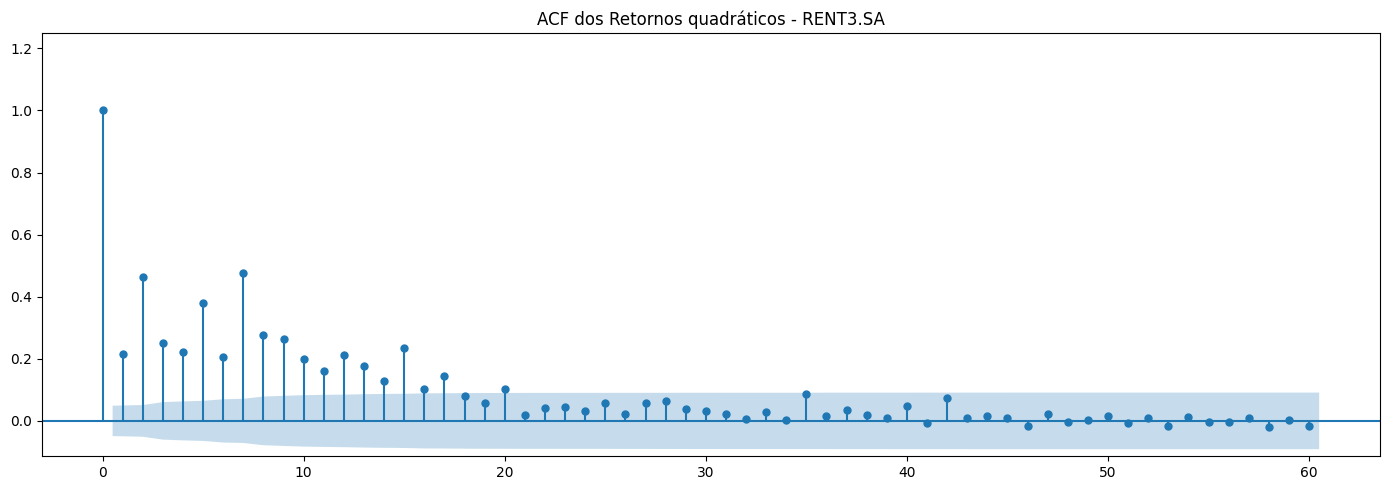

In [119]:
plot_acf_returns2(returns_squared, 'RENT3.SA')

#### Grid de parâmetros

In [120]:
#Define grid de parametros
param_grid_arch_loc = {
    'p': [15, 17, 20],
    'q': [1],
    'vol': ['ARCH'],
    'dist': ['studentst', 'skewstudent', 'ged', 'gaussian', 'normal']
}

param_grid_loc = combine_params(param_grid_garch, param_grid_arch_loc)
param_list_loc = param_grid_loc.to_dict('records')

In [121]:
# Applicar garch_aic para cada conjunto de parametros
results = []
for parms in param_list_loc:
    result = garch_aic(parms, returns['RENT3.SA'])
    results.append(result)

results_df = pd.DataFrame(results)


#### Ajustar os modelos

In [122]:
# 5 combinacoes com os menores AIC
results_df = results_df.sort_values('AIC')
results_df.head(5)

,p,q,vol,dist,AIC
35,2,2,GARCH,studentst,-7476.699110
26,1,3,GARCH,skewstudent,-7476.036549
20,1,2,GARCH,studentst,-7475.628646
50,3,2,GARCH,studentst,-7469.721231
15,1,1,GARCH,studentst,-7469.618584


In [123]:
top_result = results_df.head(1)
p = int(top_result['p'].values[0])
q = int(top_result['q'].values[0])
vol = top_result['vol'].values[0]
dist = top_result['dist'].values[0]

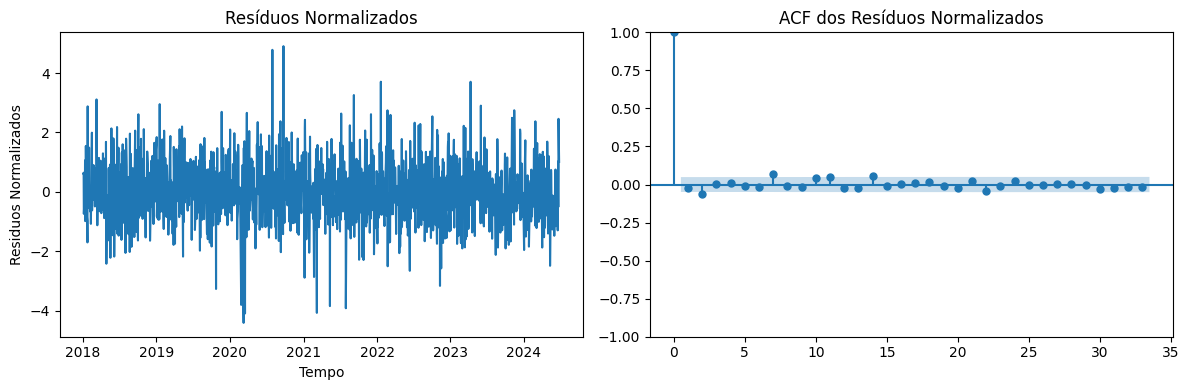


 Resultados do Ljung-Box Test para verificar se os resíduos são RB:
      lb_stat  lb_pvalue
20  31.667511   0.046973

 Resultados do Ljung-Box Test para verificar se os resíduos quadráticos são RB:
      lb_stat  lb_pvalue
20  20.180732   0.446676

 AIC:  -7476.699109549376

 BIC:  -7439.028596287829


In [124]:
ret_loc = returns['RENT3.SA']
#aplica o modelo escolhido
garch_loc = arch_model(ret_loc, p=p, q = q, vol = vol, dist = dist).fit(disp='off')
plot_residuals(garch_loc)

Resíduos padronizados e homoscedásticos, não apresentam autocorrelação significativa.
Modelo escolhido devido a menores valores de AIC

In [125]:
sigma_loc = garch_loc.conditional_volatility
sigma_loc_df = sigma_loc.to_frame().rename(columns={'cond_vol': 'RENT3.SA'})

#### Volatilidade 1 passo a frente

In [126]:
# Prever volatilidade 1 passo a frente
forecast_loc = garch_loc.forecast(horizon=1)
print(forecast_loc.variance)

                 h.1
Date                
2024-06-24  0.000594


### TIM (TIMS3)

#### Verificar normalidade e plotar ACF

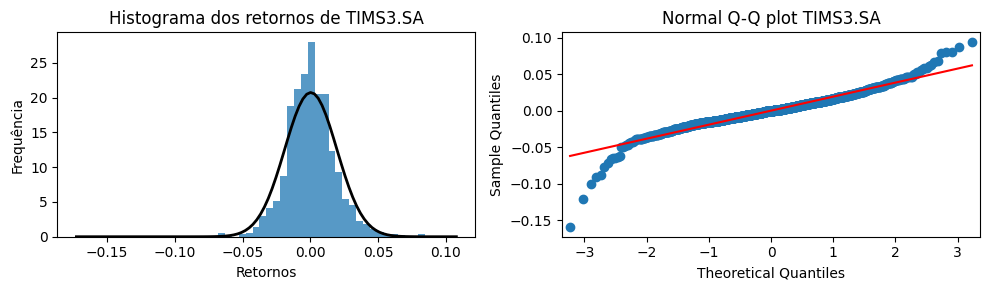

Shapiro-Wilk test statistic: 0.9460108570024588
p-value: 8.402981195935843e-24


In [127]:
check_normality(returns, 'TIMS3.SA')

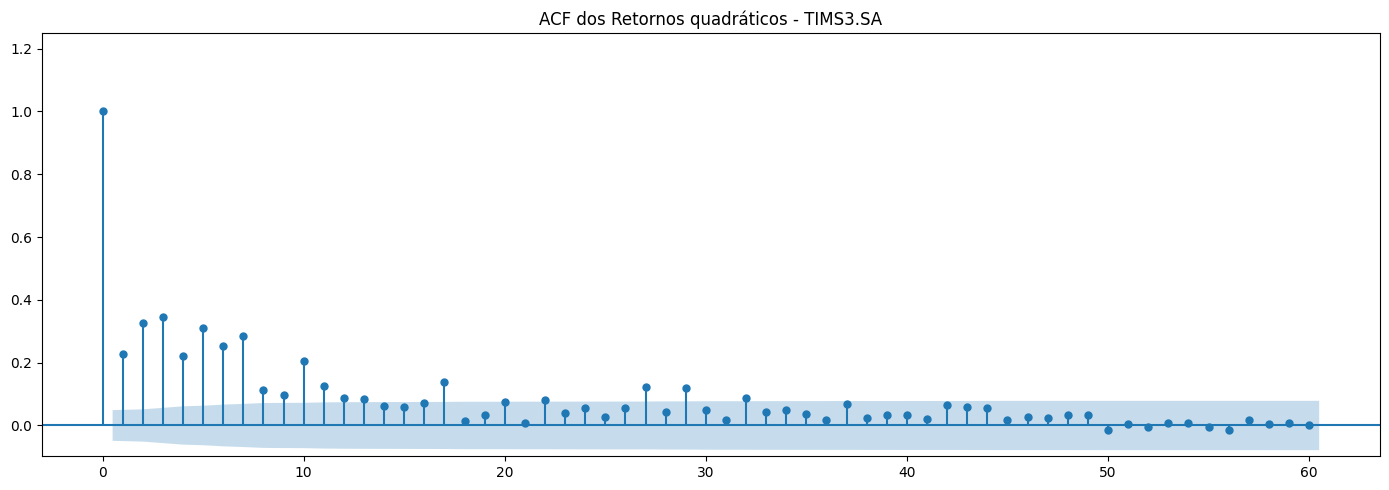

In [128]:
plot_acf_returns2(returns_squared, 'TIMS3.SA')

#### Grid de parâmetros

In [129]:
#Define grid de parametros
param_grid_arch_tim = {
    'p': [11, 17, 29],
    'q': [1],
    'vol': ['ARCH'],
    'dist': ['studentst', 'skewstudent', 'ged', 'gaussian', 'normal']
}

param_grid_tim = combine_params(param_grid_garch, param_grid_arch_tim)
param_list_tim = param_grid_tim.to_dict('records')


In [130]:
# Applicar garch_aic para cada conjunto de parametros
results = []
for parms in param_list_tim:
    result = garch_aic(parms, returns['TIMS3.SA'])
    results.append(result)

results_df = pd.DataFrame(results)

#### Ajustar os modelos

In [131]:
# 5 combinacoes com os menores AIC
results_df = results_df.sort_values('AIC')
results_df.head(5)

,p,q,vol,dist,AIC
36,2,2,GARCH,skewstudent,-8465.482342
26,1,3,GARCH,skewstudent,-8465.379939
20,1,2,GARCH,studentst,-8464.463056
25,1,3,GARCH,studentst,-8462.463201
15,1,1,GARCH,studentst,-8461.560307


In [132]:
top_result = results_df.head(1)
p = int(top_result['p'].values[0])
q = int(top_result['q'].values[0])
vol = top_result['vol'].values[0]
dist = top_result['dist'].values[0]

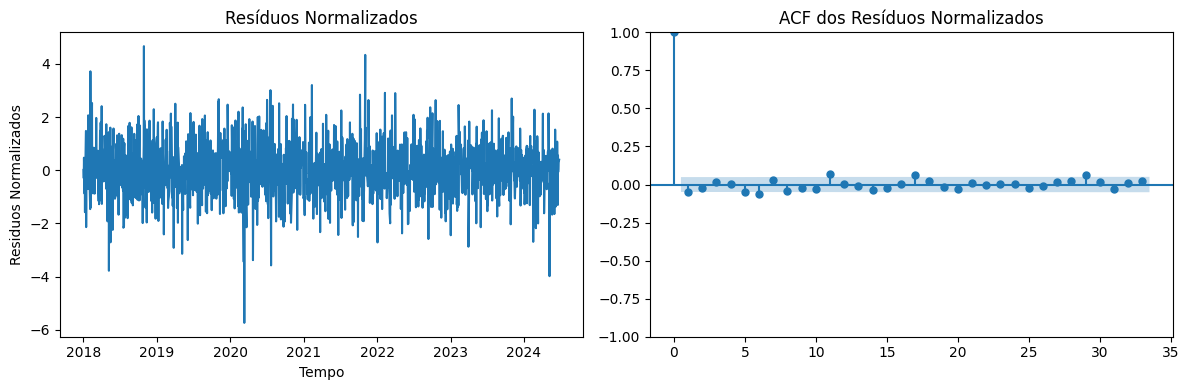


 Resultados do Ljung-Box Test para verificar se os resíduos são RB:
      lb_stat  lb_pvalue
20  41.831386   0.002909

 Resultados do Ljung-Box Test para verificar se os resíduos quadráticos são RB:
      lb_stat  lb_pvalue
20  27.834013   0.113387

 AIC:  -8465.482342378786

 BIC:  -8422.430327222732


In [133]:
ret_tim = returns['TIMS3.SA']
#aplica o modelo escolhido
garch_tim = arch_model(ret_tim, p=p, q = q, vol = vol, dist = dist).fit(disp='off')
plot_residuals(garch_tim)


Resíduos padronizados e homoscedásticos, não apresentam autocorrelação significativa.
Modelo escolhido devido a menores valores de AIC


In [134]:
sigma_tim = garch_tim.conditional_volatility
sigma_tim_df = sigma_tim.to_frame().rename(columns={'cond_vol': 'TIMS3.SA'})

#### Volatilidade 1 passo a frente

In [135]:
# Prever volatilidade 1 passo a frente
forecast_tim = garch_tim.forecast(horizon=1)
print(forecast_tim.variance)

                 h.1
Date                
2024-06-24  0.000227


### Embraer (EMBR3)

#### Verificar normalidade e plotar ACF

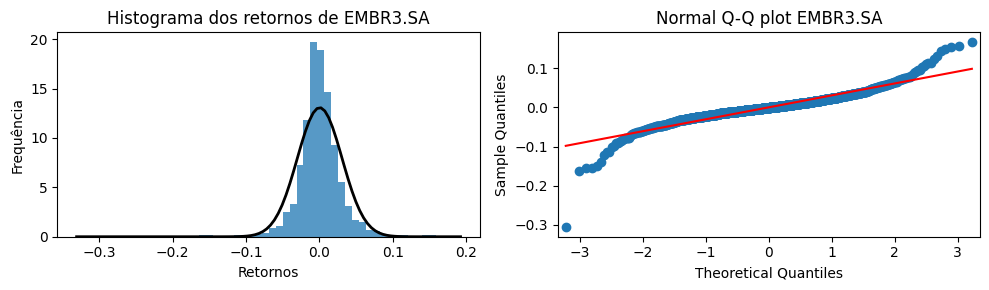

Shapiro-Wilk test statistic: 0.9000687738463232
p-value: 3.9695234609975065e-31


In [136]:
check_normality(returns, 'EMBR3.SA')

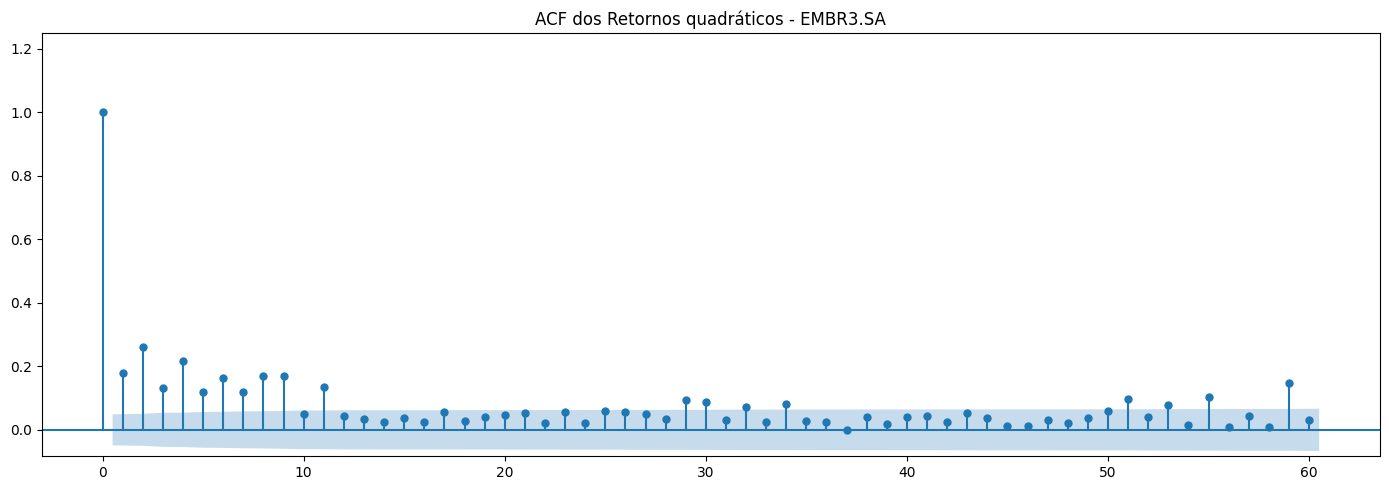

In [137]:
plot_acf_returns2(returns_squared, 'EMBR3.SA')

#### Grid de parâmetros

In [138]:
#Define grid de parametros
param_grid_arch_emb = {
    'p': [9, 11, 29],
    'q': [1],
    'vol': ['ARCH'],
    'dist': ['studentst', 'skewstudent', 'ged', 'gaussian', 'normal']
}

param_grid_emb = combine_params(param_grid_garch, param_grid_arch_emb)
param_list_emb = param_grid_emb.to_dict('records')

In [139]:
# Applicar garch_aic para cada conjunto de parametros
results = []
for parms in param_list_emb:
    result = garch_aic(parms, returns['EMBR3.SA'])
    results.append(result)

results_df = pd.DataFrame(results)

#### Ajustar os modelos

In [140]:
# 5 combinacoes com os menores AIC
results_df = results_df.sort_values('AIC')
results_df.head(5)

,p,q,vol,dist,AIC
25,1,3,GARCH,studentst,-7284.698784
26,1,3,GARCH,skewstudent,-7282.702228
40,2,3,GARCH,studentst,-7280.867577
20,1,2,GARCH,studentst,-7280.766705
41,2,3,GARCH,skewstudent,-7278.869539


In [141]:
top_result = results_df.head(1)
p = int(top_result['p'].values[0])
q = int(top_result['q'].values[0])
vol = top_result['vol'].values[0]
dist = top_result['dist'].values[0]

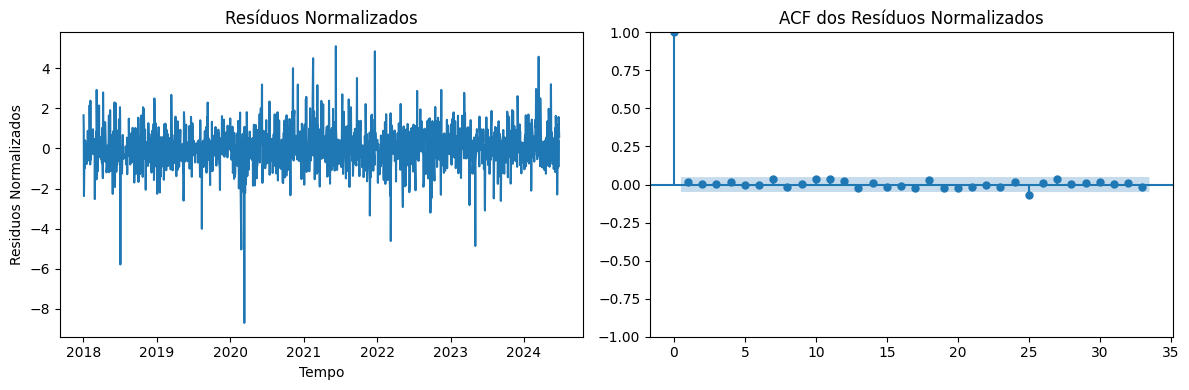


 Resultados do Ljung-Box Test para verificar se os resíduos são RB:
      lb_stat  lb_pvalue
20  14.283801    0.81582

 Resultados do Ljung-Box Test para verificar se os resíduos quadráticos são RB:
      lb_stat  lb_pvalue
20  30.671998   0.059672

 AIC:  -7284.698783823207

 BIC:  -7247.02827056166


In [142]:
ret_emb = returns['EMBR3.SA']
#aplica o modelo escolhido
garch_emb = arch_model(ret_emb, p=p, q = q, vol = vol, dist = dist).fit(disp='off')
plot_residuals(garch_emb)

Resíduos padronizados e homoscedásticos, não apresentam autocorrelação significativa.
Modelo escolhido devido a menores valores de AIC

In [143]:
sigma_emb = garch_emb.conditional_volatility
sigma_emb_df = sigma_emb.to_frame().rename(columns={'cond_vol': 'EMBR3.SA'})

#### Volatilidade 1 passo a frente

In [144]:
# Prever volatilidade 1 passo a frente
forecast_emb = garch_emb.forecast(horizon=1)
print(forecast_emb.variance.iloc[-1].values[0])

0.0006669416445149965


## 4. Prever a volatilidade um passo à frente

### Volatilidade predita para cada modelo

In [146]:
# Definir os tickers em um array
tickers_vol = ['tim', 'ele', 'ita', 'emb', 'petro', 'loc']

# Inicializar uma lista para armazenar os DataFrames
dfs_volat = []

# Iterar sobre os tickers e buscar os DataFrames correspondentes
for ticker in tickers_vol:
    df_name = f'sigma_{ticker}_df'  # Construir o nome do DataFrame
    if df_name in globals():  # Verificar se o DataFrame existe no escopo global
        dfs_volat.append(globals()[df_name])  # Adicionar o DataFrame à lista

# Unir os DataFrames usando concatenação ao longo do eixo das colunas (axis=1)
merged_df_volat = pd.concat(dfs_volat, axis=1)

merged_df_volat.columns.name = "Ticker"

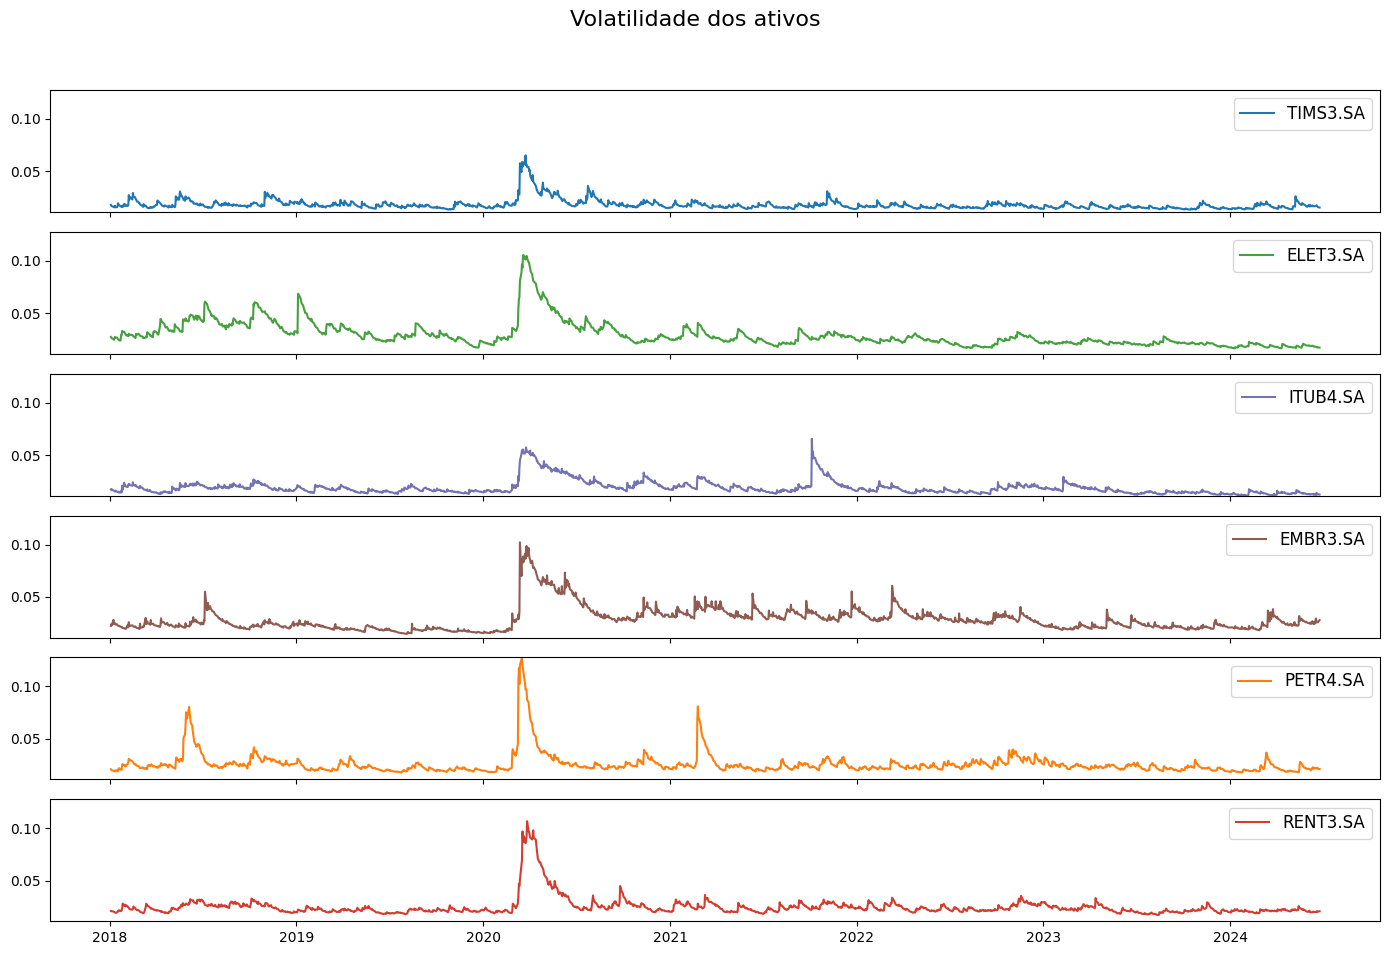

In [155]:
fig, axes = plt.subplots(6, 1, figsize=(14, 10), sharex=True)

# Encontrar os limites comuns do eixo y
y_min = min(merged_df_volat.min())
y_max = max(merged_df_volat.max())

# Gerar os gráficos das volatilidades para cada ativo
for i, ticker in enumerate(merged_df_volat.columns):
    axes[i].plot(merged_df_volat.index, merged_df_volat[ticker], label=ticker, color=color_dict[ticker])
    axes[i].set_ylim(y_min, y_max)  # Definir os mesmos limites do eixo y para cada gráfico
    axes[i].legend(loc='upper right', fontsize='large')

# Adicionar um título geral ao conjunto de gráficos
fig.suptitle('Volatilidade dos ativos', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajustar o layout para dar espaço ao título
plt.show()

### Volatilidade predita 1 passo a frente

In [161]:
# Modelos de volatilidade
models = {'PETR4.SA': arch_petro, 'ITUB4.SA': garch_ita, 'ELET3.SA': garch_ele, 
          'RENT3.SA': garch_loc, 'TIMS3.SA': garch_tim, 'EMBR3.SA': garch_emb}

# Dicionário para armazenar as previsões de volatilidade
vol_pred = {}
for key, value in models.items():
    forecast = value.forecast(horizon=1)
    vol_pred[key] = forecast.variance.iloc[-1].values[0]

# Converter o dicionário em DataFrame
vol_pred = pd.DataFrame.from_dict(vol_pred, orient='index', columns=['Volatilidade predita 1 passo a frente'])

# Ordenar o DataFrame pela coluna 'Volatilidade predita 1 passo a frente'
vol_pred_sorted = vol_pred.sort_values(by='Volatilidade predita 1 passo a frente')

# Imprimir o DataFrame ordenado
vol_pred_sorted

,Volatilidade predita 1 passo a frente
ITUB4.SA,0.000165
TIMS3.SA,0.000227
ELET3.SA,0.000285
PETR4.SA,0.000405
RENT3.SA,0.000594
EMBR3.SA,0.000667


## 5. Calcular o retorno e a ajustar modelo de volatilidade no portfólio (pesos iniciais)

### Retorno

In [167]:
#Define pesos iniciais
pesos_iniciais = np.array([0.16, 0.16, 0.2, 0.16, 0.16, 0.16])

In [168]:
#Calcula o retorno do portfólio
portfolio_returns = (returns * pesos_iniciais).sum(axis=1).to_frame('portfolio')

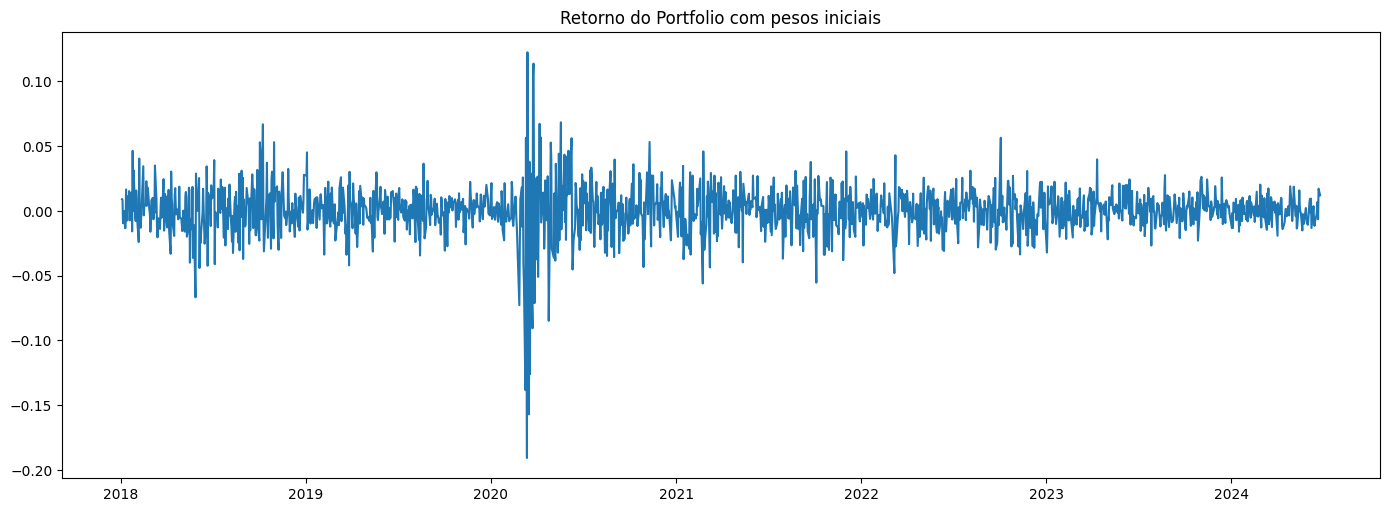

In [169]:
# Plotando os retornos do portfolio com os pesos iniciais
plt.figure(figsize=(14, 5))
plt.plot(portfolio_returns.index, portfolio_returns['portfolio'], color= "#1F77B4", label='Portfolio')
plt.tight_layout()
plt.title('Retorno do Portfolio com pesos iniciais')
plt.show()

### Ajuste do modelo

#### Normalidade

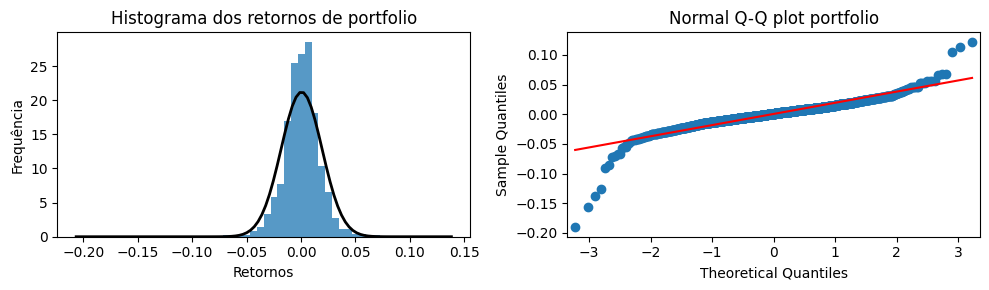

Shapiro-Wilk test statistic: 0.8812267399954345
p-value: 2.2735738288122484e-33


In [170]:
check_normality(portfolio_returns, 'portfolio')

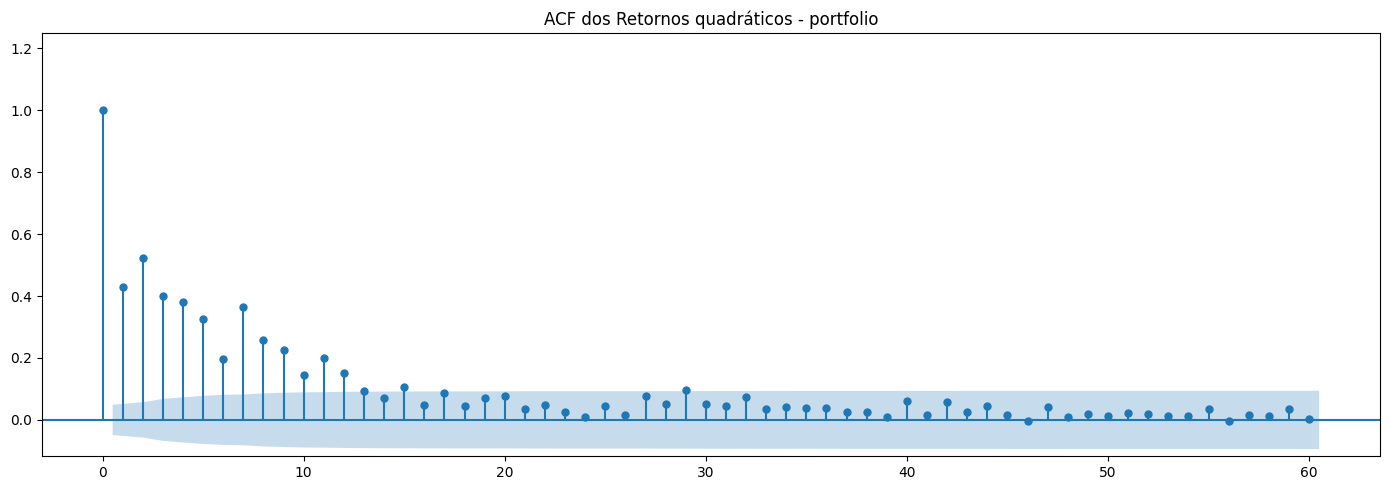

In [171]:
squared_portfolio_returns = portfolio_returns**2

plot_acf_returns2(squared_portfolio_returns, 'portfolio')

#### Grid de parâmetros

In [172]:
#Define grid de parametros
param_grid_arch_port = {
    'p': [12, 13, 15],
    'q': [1],
    'vol': ['ARCH'],
    'dist': ['studentst', 'skewstudent', 'ged', 'gaussian', 'normal']
}

param_grid_port = combine_params(param_grid_garch, param_grid_arch_port)
param_list_port = param_grid_port.to_dict('records')

# Applicar garch_aic para cada conjunto de parametros
results = []
for parms in param_list_port:
    result = garch_aic(parms, portfolio_returns)
    results.append(result)

    results_df = pd.DataFrame(results)

c:\Users\Giovana\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Giovana\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Giovana\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Giovana\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:

#### Fit modelo

In [173]:
# 5 combinacoes com os menores AIC
results_df = results_df.sort_values('AIC')
results_df.head(5)

,p,q,vol,dist,AIC
17,1,1,GARCH,ged,-8896.095589
22,1,2,GARCH,ged,-8890.915557
32,2,1,GARCH,ged,-8890.571942
47,3,1,GARCH,ged,-8885.379249
27,1,3,GARCH,ged,-8884.001178


In [174]:
top_result = results_df.head(1)
p = int(top_result['p'].values[0])
q = int(top_result['q'].values[0])
vol = top_result['vol'].values[0]
dist = top_result['dist'].values[0]

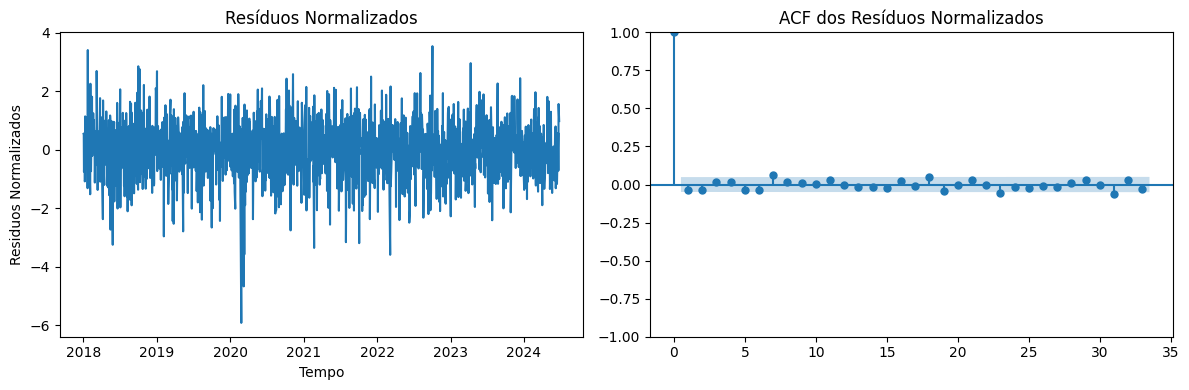


 Resultados do Ljung-Box Test para verificar se os resíduos são RB:
      lb_stat  lb_pvalue
20  27.001546    0.13522

 Resultados do Ljung-Box Test para verificar se os resíduos quadráticos são RB:
      lb_stat  lb_pvalue
20  49.079057     0.0003

 AIC:  -8896.095588867553

 BIC:  -8869.188079395019


In [175]:
garch_portfolio = arch_model(portfolio_returns, p=p, q=q, vol = vol, dist = dist).fit(disp='off')
plot_residuals(garch_portfolio)

#### Volatilidade 1 passo a frente

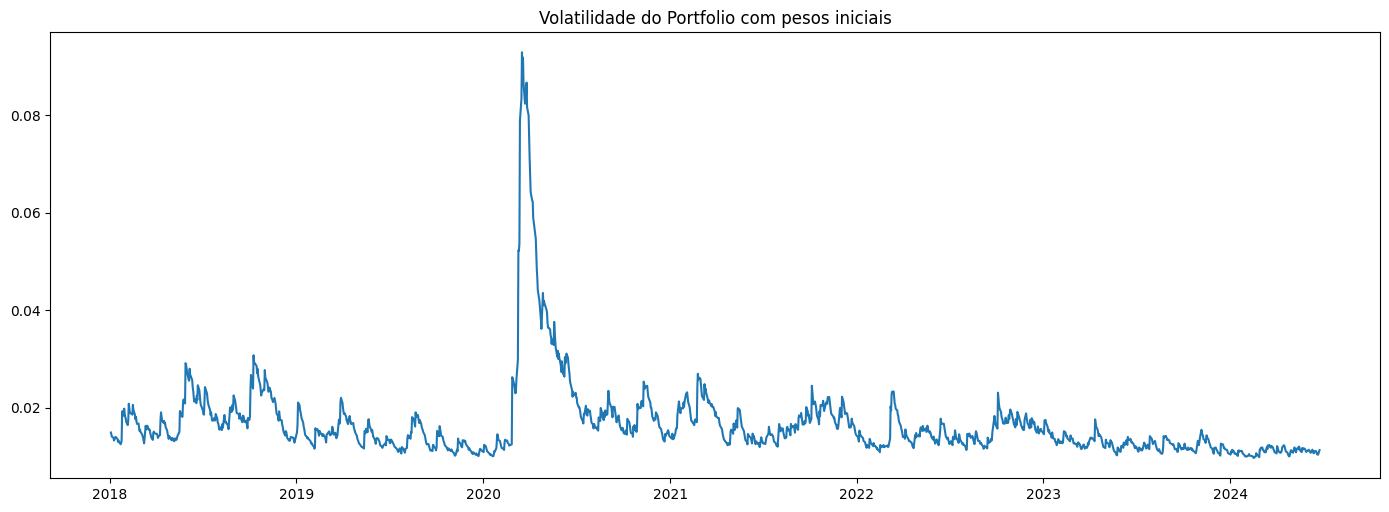

In [210]:
# Plotando a volatilidade do portfólio com os pesos iniciais

sigma_port = garch_portfolio.conditional_volatility
sigma_port_df = sigma_port.to_frame().rename(columns={'cond_vol': 'Portfolio'})

plt.figure(figsize=(14, 5))
plt.plot(sigma_port_df.index, sigma_port_df['Portfolio'], color= "#1F77B4", label='Portfolio')
plt.tight_layout()
plt.title('Volatilidade do Portfolio com pesos iniciais')
plt.show()

In [177]:
# Prever volatilidade 1 passo a frente
forecast_portfolio = garch_portfolio.forecast(horizon=1)
variance_forecast_df = pd.DataFrame(forecast_portfolio.variance)
variance_forecast_df

,h.1
Date,
2024-06-24,0.000132


## 6. Calcular betas individuais usando regressão simples (pesos iniciais)

In [178]:
#Pegar dados do mercado
hist_ibov = yf.download('^BVSP', start="2018-01-01")['Adj Close']

# Calcular os retornos do índice de mercado
market_returns = np.log(hist_ibov / hist_ibov.shift(1)).dropna()
market_returns = market_returns.rename('BVSP')

# Remover informações de fuso horário de ambos os índices
returns.index = returns.index.tz_localize(None)
market_returns.index = market_returns.index.tz_localize(None)

# Unir os retornos dos ativos e do índice de mercado
combined_returns = returns.join(market_returns, how='inner')

# Função para calcular o beta com regressão linear
def calculate_beta(df, market_col):
    X = df[market_col]
    X = sm.add_constant(X)
    betas = {}
    for ticker in df.columns:
        if ticker != market_col:
            y = df[ticker]
            model = sm.OLS(y, X).fit()
            betas[ticker] = model.params[1]
    return betas

# Calcular os betas
betas = calculate_beta(combined_returns, 'BVSP')

# Converter os betas em um DataFrame
betas_df = pd.DataFrame(list(betas.items()), columns=['Ticker', 'Beta'])

betas_ordenado = betas_df.sort_values(by='Beta', ascending=False).reset_index(drop=True)

# Mostrar o DataFrame de betas
betas_ordenado

[*********************100%%**********************]  1 of 1 completed


,Ticker,Beta
0,PETR4.SA,1.357393
1,ELET3.SA,1.308911
2,RENT3.SA,1.245934
3,EMBR3.SA,1.008707
4,ITUB4.SA,0.960293
5,TIMS3.SA,0.669892


## 7.  Calcular beta estático do portfolio (pesos iniciais)

In [181]:
# Transpor o DataFrame
betas_df_transposed = betas_df.transpose()
betas_df_transposed.columns = betas_df_transposed.iloc[0]
betas_df_transposed = betas_df_transposed[1:]

betas_df_transposed

Ticker,ELET3.SA,EMBR3.SA,ITUB4.SA,PETR4.SA,RENT3.SA,TIMS3.SA
Beta,1.308911,1.008707,0.960293,1.357393,1.245934,0.669892


In [182]:
beta_portfolio = (betas_df_transposed * pesos_iniciais).sum(axis=1).to_frame('portfolio')
beta_portfolio

,portfolio
Beta,1.086593


## 8. Fazer otimização dos pesos do portfólio

### Otimização

In [184]:
#Gerando a matriz de covariância (252 dias úteis)
cov_mat = returns.cov() * 252

In [185]:
# Simulando 5000 portfolios
num_port = 5000

# Criando array vazio para armazenar pesos do portfolio
pesos_port = np.zeros((num_port, len(returns.columns)))

# Criando array vazio para armazenar retornos do portfolio
port_returns = np.zeros((num_port))

# Criando array vazio para armazenar riscos do portfolio
port_risk = np.zeros((num_port))

# Criando array vazio para armazenar índice de sharpe do portfolio
sharpe_ratio = np.zeros((num_port))

In [186]:
# Função para calcular índice de sharpe e risco de cada um dos portfolios simulados
for i in range(num_port):
  pesos = np.random.uniform(size = len(returns.columns))
  pesos = pesos/np.sum(pesos)

  # Guardando pesos no array
  pesos_port[i,:] = pesos

  # Retornos do portfolio
  port_ret = np.sum(returns.mean() * pesos)
  port_ret = (port_ret + 1) ** 252 - 1

  # Guardando retornos no array
  port_returns[i] = port_ret


  # Risco do portfolio
  port_sd = np.sqrt(np.dot(pesos.T, np.dot(cov_mat, pesos)))

  port_risk[i] = port_sd

  # Índice de Sharpe do Portfolio
  # Assumindo Taxa livre de risco de 10.5%
  risk_free_rate = 0.105

  # Retorno em excesso do portfólio (retorno do portfólio - taxa livre de risco)
  excess_return = port_ret - risk_free_rate

  # Índice de Sharpe do portfólio ajustado para a taxa livre de risco
  sr = excess_return / port_sd
  sharpe_ratio[i] = sr

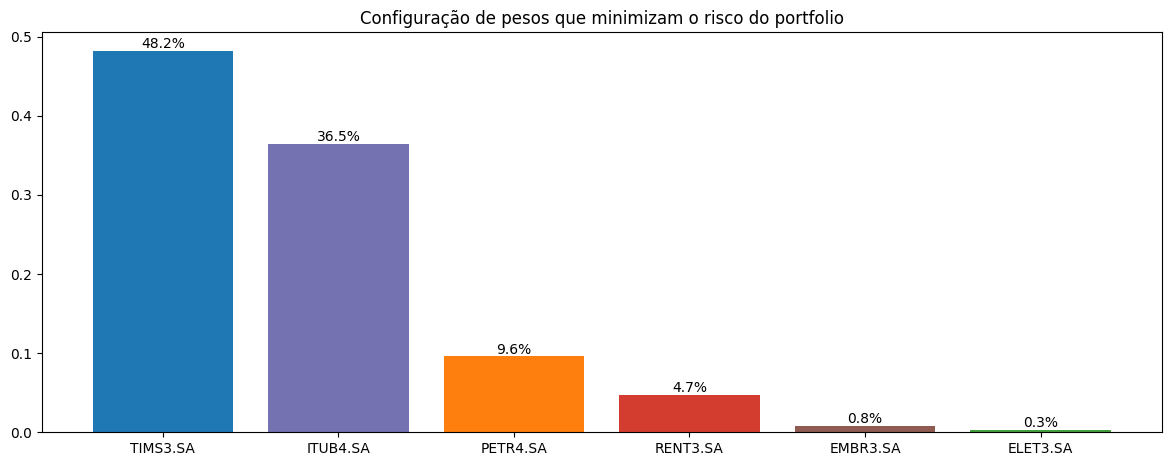

In [192]:
# Plot dos pesos que minimizam o risco do portfolio
names = returns.columns

pesos_min_var = pesos_port[port_risk.argmin()]
pesos_min_var = pd.Series(pesos_min_var, index=names)
pesos_min_var = pesos_min_var.sort_values(ascending=False)

fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Configuração dos rótulos e título
# Plotando os pesos com cores personalizadas
bars = ax1.bar(pesos_min_var.index, pesos_min_var, color=[color_dict[ticker] for ticker in pesos_min_var.index])

ax1.bar_label(bars, labels=[f'{height * 100:.1f}%' for height in pesos_min_var])

# Exibir o gráfico
plt.title('Configuração de pesos que minimizam o risco do portfolio')
plt.show()

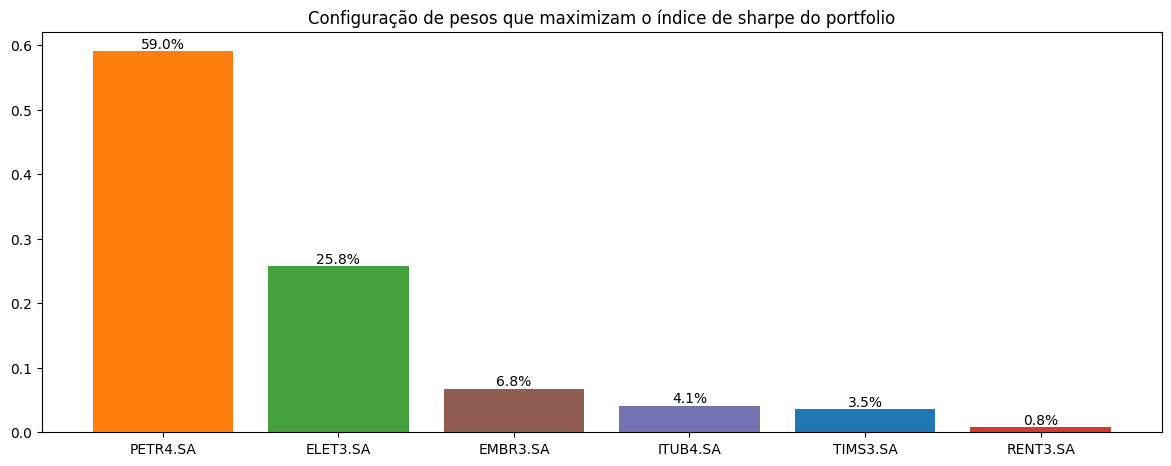

In [194]:
# Plot dos pesos que maximizam o índice de sharpe
pesos_max_sr = pesos_port[sharpe_ratio.argmax()]
pesos_max_sr = pd.Series(pesos_max_sr, index=names)
pesos_max_sr = pesos_max_sr.sort_values(ascending=False)

fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Plotando os pesos
bars = ax1.bar(pesos_max_sr.index, pesos_max_sr, color=[color_dict[ticker] for ticker in pesos_max_sr.index])

ax1.bar_label(bars, labels=[f'{height * 100:.1f}%' for height in pesos_max_sr])

# Exibir o gráfico
plt.title('Configuração de pesos que maximizam o índice de sharpe do portfolio')
plt.show()

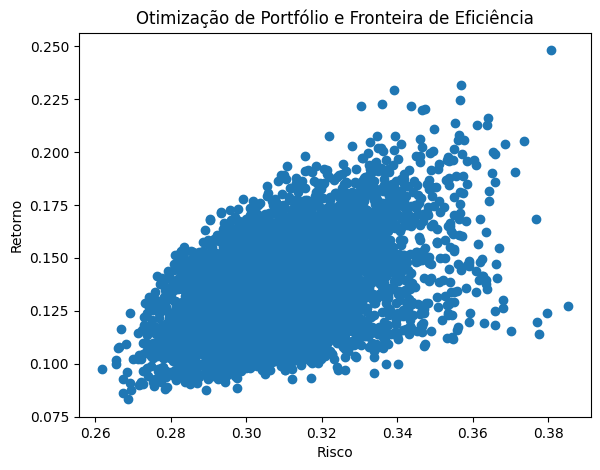

In [196]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.set_xlabel('Risco')
ax1.set_ylabel("Retorno")
ax1.set_title("Otimização de Portfólio e Fronteira de Eficiência")
plt.scatter(port_risk, port_returns)
plt.show();

### Retorno do Portfólio (Inicial e Otimizado)

In [197]:
#ORDENANDO ARRAY DE PESOS FINAIS (COM BASE NO ÍNDICE DE SHARPE)
tickers_ordem = returns.columns
pesos_finais = pesos_max_sr[tickers_ordem].values

In [198]:
#CALCULANDO O RETORNO DO PORTFOLIO
portfolio_returns_otimizado = (returns * pesos_finais).sum(axis=1).to_frame('Retorno Portfolio Otimizado')

In [199]:
#RETORNO ACUMULADO PORTFOLIO INICIAL
portfolio_returns['Retorno Acumulado'] = (1 + portfolio_returns['portfolio']).cumprod() - 1
retorno_acumulado_hoje = portfolio_returns['Retorno Acumulado'].iloc[-1]
retorno_acumulado_hoje

0.6854716808556847

In [201]:
#RETORNO ACUMULADO PORTFOLIO OTIMIZADO
portfolio_returns_otimizado['Retorno Acumulado'] = (1 + portfolio_returns_otimizado['Retorno Portfolio Otimizado']).cumprod() - 1
retorno_acumulado_otimizado_hoje = portfolio_returns_otimizado['Retorno Acumulado'].iloc[-1]
retorno_acumulado_otimizado_hoje

1.552845893303699

### Modelo de Volatilidade do Portfólio Otimizado

#### Normalidade

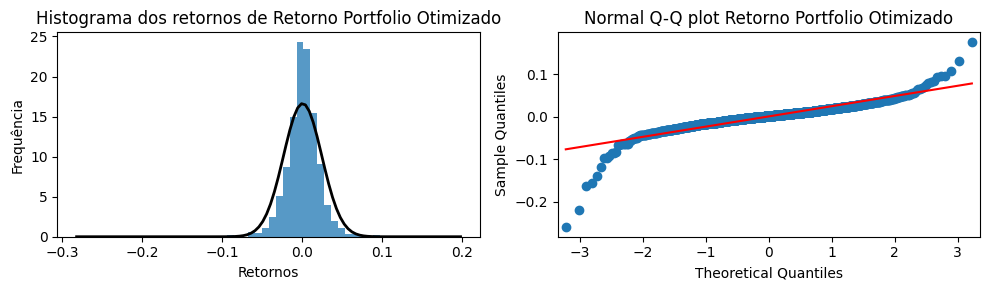

Shapiro-Wilk test statistic: 0.8570804109741967
p-value: 7.306303420317167e-36


In [202]:
check_normality(portfolio_returns_otimizado, 'Retorno Portfolio Otimizado')

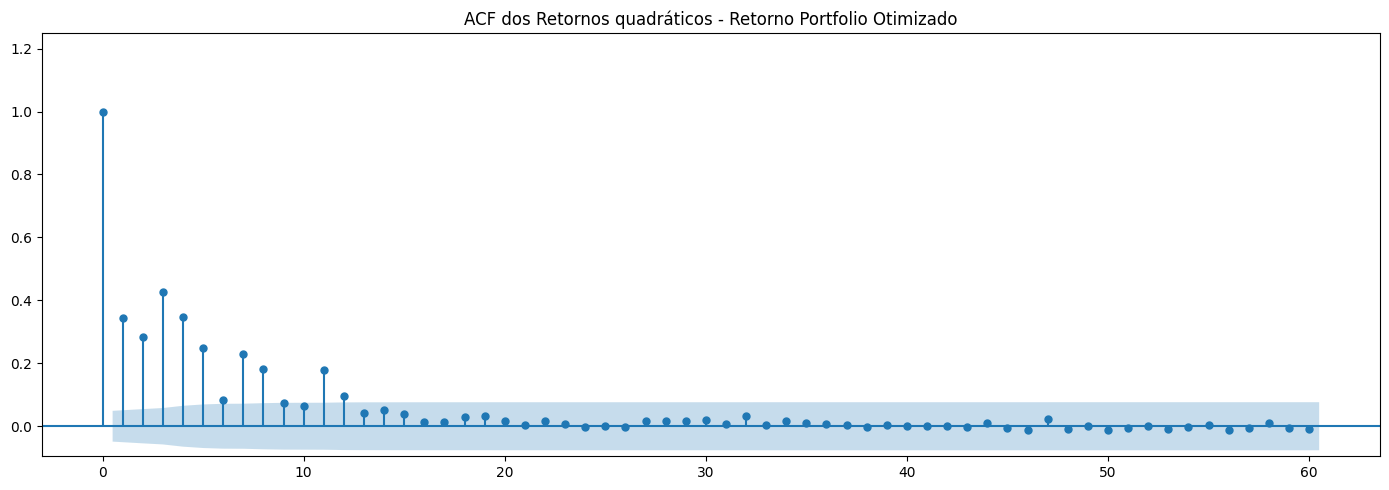

In [103]:
squared_portfolio_otimizado_returns = portfolio_returns_otimizado**2

plot_acf_returns2(squared_portfolio_otimizado_returns, 'Retorno Portfolio Otimizado')

#### Grid de parâmetros

In [203]:
retornos_otimizados = portfolio_returns_otimizado['Retorno Portfolio Otimizado']

#Define grid de parametros
param_grid_arch_port_otim = {
    'p': [8, 11, 12],
    'q': [1],
    'vol': ['ARCH'],
    'dist': ['studentst', 'skewstudent', 'ged', 'gaussian', 'normal']
}

param_grid_port_otim = combine_params(param_grid_garch, param_grid_arch_port_otim)
param_list_port_otim = param_grid_port_otim.to_dict('records')

# Applicar garch_aic para cada conjunto de parametros
results = []
for parms in param_list_port_otim:
    result = garch_aic(parms, retornos_otimizados)
    results.append(result)

    results_df = pd.DataFrame(results)

c:\Users\Giovana\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Giovana\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Giovana\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Giovana\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:

#### Aplicar modelo de volatilidade

In [204]:
# 5 combinacoes com os menores AIC
results_df = results_df.sort_values('AIC')
results_df.head(5)

,p,q,vol,dist,AIC
10,12,1,ARCH,studentst,-8168.148860
12,12,1,ARCH,ged,-8156.424292
27,1,3,GARCH,ged,-8146.789896
42,2,3,GARCH,ged,-8137.396880
57,3,3,GARCH,ged,-8131.491994


In [205]:
top_result = results_df.head(1)
p = int(top_result['p'].values[0])
q = int(top_result['q'].values[0])
vol = top_result['vol'].values[0]
dist = top_result['dist'].values[0]

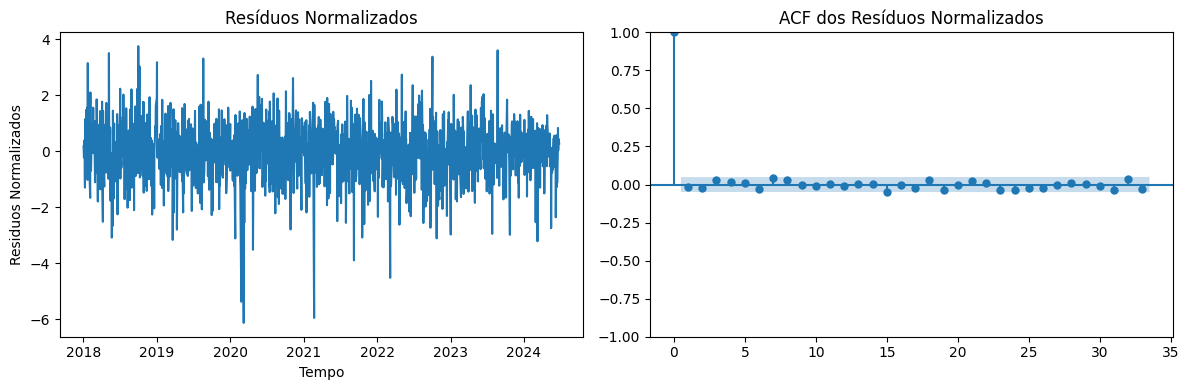


 Resultados do Ljung-Box Test para verificar se os resíduos são RB:
      lb_stat  lb_pvalue
20  18.176887   0.575757

 Resultados do Ljung-Box Test para verificar se os resíduos quadráticos são RB:
      lb_stat  lb_pvalue
20  27.250941    0.12835

 AIC:  -8168.148859941975

 BIC:  -8087.426331524375


In [206]:
arch_portfolio_otimizado = arch_model(retornos_otimizados, p=p, q=q, vol = vol, dist = dist).fit(disp='off')
plot_residuals(arch_portfolio_otimizado)

#### Volatilidade 1 passo a frente

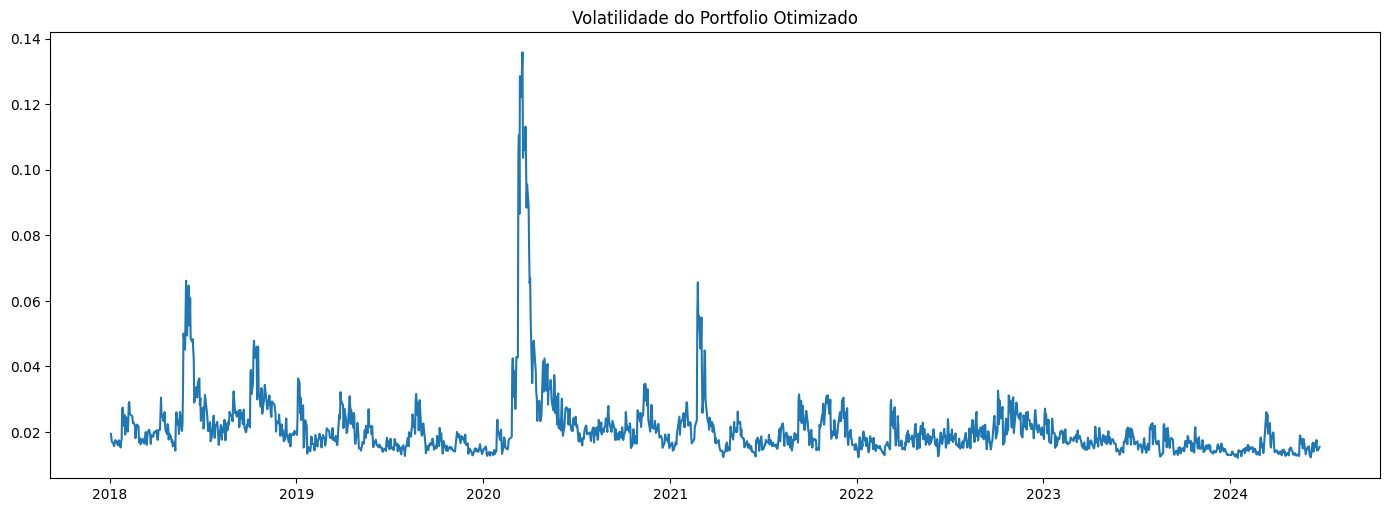

In [211]:
# Plotando a volatilidade do porfólio otimizado
sigma_port_otim = arch_portfolio_otimizado.conditional_volatility
sigma_port_df_otim = sigma_port_otim.to_frame().rename(columns={'cond_vol': 'Portfolio Otimizado'})

plt.figure(figsize=(14, 5))
plt.plot(sigma_port_df_otim.index, sigma_port_df_otim['Portfolio Otimizado'], color= "#1F77B4", label='Portfolio Otimizado')
plt.tight_layout()
plt.title('Volatilidade do Portfolio Otimizado')
plt.show()

In [209]:
# Prever volatilidade 1 passo a frente
forecast_portfolio_otimizado = arch_portfolio_otimizado.forecast(horizon=1)
variance_forecast_df = pd.DataFrame(forecast_portfolio_otimizado.variance)
variance_forecast_df

,h.1
Date,
2024-06-24,0.000218


#### Beta Portfólio Otimizado

In [108]:
beta_portfolio_otimizado = (betas_df_transposed * pesos_finais).sum(axis=1).to_frame('Portfolio Otimizado')
beta_portfolio_otimizado

,Portfolio Otimizado
Beta,1.275013
